In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import font_manager
import seaborn as sns
import os
import folium
from folium import Icon
from folium.plugins import HeatMap
import geopandas as gpd
import json
import shapefile
import re

In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fm.fontManager.addfont('/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf')
plt.rc('font', family='NanumBarunGothic')

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (29.1 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126101 files and direc

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/광진구 공모전 데이터/db/final후보지.csv")
df.head()

,A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,...,유치원수,초등학교수,키즈카페수,공원부지수,노인복지수,주차장수,주거부지수,평균기울기,평균유소년수,평균노인수
0,103389737,1121510100100290001,1121510100,서울특별시 광진구 중곡동,1,일반,29-1,29-1 대,2024,1,...,1.0,1.0,1.0,1,1.0,NaN,243,5.355,1345,4323
1,103391159,1121510400103190033,1121510400,서울특별시 광진구 광장동,1,일반,319-33,319-33 대,2024,1,...,NaN,NaN,NaN,1,1.0,NaN,43,1.939,5128,4359
2,103390312,1121510400105770002,1121510400,서울특별시 광진구 광장동,1,일반,577-2,577-2잡,2024,1,...,1.0,1.0,NaN,3,1.0,NaN,127,2.882,5128,4359
3,103390351,1121510400105770003,1121510400,서울특별시 광진구 광장동,1,일반,577-3,577-3잡,2024,1,...,1.0,1.0,NaN,1,NaN,NaN,33,3.076,5128,4359
4,103390918,1121510500100720001,1121510500,서울특별시 광진구 자양동,1,일반,72-1,72-1대,2024,1,...,1.0,NaN,1.0,2,NaN,NaN,75,0.845,2117,4641


In [ ]:
col_dict = {
    "A0": "도형ID",
    "A1": "고유번호",
    "A2": "법정동코드",
    "A3": "법정동명",
    "A4": "대장구분코드",
    "A5": "대장구분명",
    "A6": "지번",
    "A7": "지번지목부호",
    "A8": "기준연도",
    "A9": "기준월",
    "A10": "지목코드",
    "A11": "지목명",
    "A12": "토지면적",
    "A13": "용도지역코드1",
    "A14": "용도지역명1",
    "A15": "용도지역코드2",
    "A16": "용도지역명2",
    "A17": "토지이용상황코드",
    "A18": "토지이용상황명",
    "A19": "지형높이코드",
    "A20": "지형높이명",
    "A21": "지형형상코드",
    "A22": "지형형상명",
    "A23": "도로측면코드",
    "A24": "도로측면명",
    "A25": "공시지가",
    "A26": "데이터기준일자",
    "기존어린이공원수": "인근공원_수",
    "초등학교수": "초등학교_수",
    "유치원수": "유치원_수",
    "아동센터수": "지역아동센터_수",
    "키즈카페수": "키즈카페_수",
    "유해시설수": "청소년유해업소_수",
    "주차장수": "공영주차장_수",
    "노인복지수": "노인복지시설_수",
    "평균유소년수": "유소년_인구수",
    "평균노인수": "노인_인구수",
    "평균기울기": "평균_기울기"
}


road_score_map = {
    '광대세각': 4,
    '광대소각': 3,
    '세로한면(가)': 2,
    '소로한면': 1
}

df = df.rename(columns=col_dict).fillna(0)
df['도로측면_점수'] = df['도로측면명'].map(road_score_map)

In [ ]:
df.columns

Index(['도형ID', '고유번호', '법정동코드', '법정동명', '대장구분코드', '대장구분명', '지번', '지번지목부호',
       '기준연도', '기준월', '지목코드', '지목명', '토지면적', '용도지역코드1', '용도지역명1', '용도지역코드2',
       '용도지역명2', '토지이용상황코드', '토지이용상황명', '지형높이코드', '지형높이명', '지형형상코드', '지형형상명',
       '도로측면코드', '도로측면명', '공시지가', '데이터기준일자', '인근공원_수', '청소년유해업소_수', '지역아동센터_수',
       '유치원_수', '초등학교_수', '키즈카페_수', '공원부지수', '노인복지시설_수', '공영주차장_수', '주거부지수',
       '평균_기울기', '유소년_인구수', '노인_인구수', '도로측면_점수'],
      dtype='object')

## 지표 정규화 (min-max 정규화)

In [ ]:
# 클수록 좋은 지표
benefit_cols = ['유소년_인구수', '노인_인구수', '유치원_수', '도로측면_점수', '공영주차장_수',
                '초등학교_수', '키즈카페_수', '노인복지시설_수', '지역아동센터_수']
# 작을수록 좋은 지표
cost_cols = ['평균_기울기', '청소년유해업소_수', '공시지가', '인근공원_수']

def normalize(df, cols, reverse=False):
    df_norm = df.copy()
    for col in cols:
        min_val = df[col].min()
        max_val = df[col].max()
        if max_val - min_val == 0:
            df_norm[col] = 0
        else:
            if reverse:
                df_norm[col] = (max_val - df[col]) / (max_val - min_val)
            else:
                df_norm[col] = (df[col] - min_val) / (max_val - min_val)
    return df_norm

df_norm = normalize(df, benefit_cols, reverse=False)
df_norm = normalize(df_norm, cost_cols, reverse=True)

print(df_norm.head())


        도형ID                 고유번호       법정동코드           법정동명  대장구분코드 대장구분명  \
0  103389737  1121510100100290001  1121510100  서울특별시 광진구 중곡동       1    일반   
1  103391159  1121510400103190033  1121510400  서울특별시 광진구 광장동       1    일반   
2  103390312  1121510400105770002  1121510400  서울특별시 광진구 광장동       1    일반   
3  103390351  1121510400105770003  1121510400  서울특별시 광진구 광장동       1    일반   
4  103390918  1121510500100720001  1121510500  서울특별시 광진구 자양동       1    일반   

       지번    지번지목부호  기준연도  기준월  ...  초등학교_수 키즈카페_수  공원부지수  노인복지시설_수 공영주차장_수  \
0    29-1    29-1 대  2024    1  ...     1.0    1.0      1      0.25     0.0   
1  319-33  319-33 대  2024    1  ...     0.0    0.0      1      0.25     0.0   
2   577-2    577-2잡  2024    1  ...     1.0    0.0      3      0.25     0.0   
3   577-3    577-3잡  2024    1  ...     1.0    0.0      1      0.00     0.0   
4    72-1     72-1대  2024    1  ...     0.0    1.0      2      0.00     0.0   

   주거부지수    평균_기울기   유소년_인구수    노인_인구수   도로측면_점수  
0    

## 중요도 가중치 설정

In [ ]:
# @title 모델링 가중치
modeling_weights = {
    "키즈카페_수": 0.160860,
    "노인복지시설_수": 0.101082,
    "초등학교_수": 0.096065,
    "지역아동센터_수": 0.094835,
    "인근공원_수": 0.085893,
    "평균_기울기": 0.083637,
    "유치원_수": 0.079437,
    "청소년유해업소_수": 0.071293,
    "공시지가": 0.063399,
    "노인_인구수": 0.058908,
    "공영주차장_수": 0.055412,
    "유소년_인구수": 0.049179
}

df_modeling = pd.DataFrame(list(modeling_weights.items()), columns=['지표', '중요도'])
df_modeling.sort_values(by="중요도", ascending=False)

,지표,중요도
0,키즈카페_수,0.160860
1,노인복지시설_수,0.101082
2,초등학교_수,0.096065
3,지역아동센터_수,0.094835
4,인근공원_수,0.085893
5,평균_기울기,0.083637
6,유치원_수,0.079437
7,청소년유해업소_수,0.071293
8,공시지가,0.063399
9,노인_인구수,0.058908


In [ ]:
score_columns = modeling_weights.keys()
weights = df_modeling.set_index('지표').loc[score_columns]['중요도'].values
df_norm['가중합_점수'] = df_norm[score_columns].dot(weights)
df2 = df_norm.sort_values(by='가중합_점수', ascending=False)
df2

,도형ID,고유번호,법정동코드,법정동명,대장구분코드,대장구분명,지번,지번지목부호,기준연도,기준월,...,키즈카페_수,공원부지수,노인복지시설_수,공영주차장_수,주거부지수,평균_기울기,유소년_인구수,노인_인구수,도로측면_점수,가중합_점수
0,103389737,1121510100100290001,1121510100,서울특별시 광진구 중곡동,1,일반,29-1,29-1 대,2024,1,...,1.0,1,0.25,0.0,243,0.000000,0.177787,0.854396,1.000000,0.631674
5,103390177,1121510500106800081,1121510500,서울특별시 광진구 자양동,1,일반,680-81,680-81대,2024,1,...,0.0,2,0.75,0.0,350,0.879379,0.277766,0.822344,0.666667,0.515475
3,103390351,1121510400105770003,1121510400,서울특별시 광진구 광장동,1,일반,577-3,577-3잡,2024,1,...,0.0,1,0.00,0.0,33,0.505322,1.000000,0.870879,0.000000,0.490046
2,103390312,1121510400105770002,1121510400,서울특별시 광진구 광장동,1,일반,577-2,577-2잡,2024,1,...,0.0,3,0.25,0.0,127,0.548337,1.000000,0.870879,0.000000,0.483647
6,103390708,1121510500106900033,1121510500,서울특별시 광진구 자양동,1,일반,690-33,690-33대,2024,1,...,0.0,3,1.00,0.0,224,0.839246,0.314280,0.974359,1.000000,0.469739
4,103390918,1121510500100720001,1121510500,서울특별시 광진구 자양동,1,일반,72-1,72-1대,2024,1,...,1.0,2,0.00,0.0,75,1.000000,0.345577,1.000000,1.000000,0.455120
1,103391159,1121510400103190033,1121510400,서울특별시 광진구 광장동,1,일반,319-33,319-33 대,2024,1,...,0.0,1,0.25,0.0,43,0.757428,1.000000,0.870879,0.333333,0.381168
8,103391524,1121510900103740004,1121510900,서울특별시 광진구 군자동,1,일반,374-4,374-4 대,2024,1,...,0.0,8,0.25,1.0,157,0.867627,0.059987,0.038462,0.666667,0.341806
7,103390741,1121510700100010037,1121510700,서울특별시 광진구 화양동,1,일반,1-37,1-37대,2024,1,...,0.0,3,0.00,1.0,236,0.790022,0.000000,0.000000,0.666667,0.210452


In [ ]:
df2["주소"] = df2["법정동명"] + " " + df2["지번"]

In [ ]:
df2[["주소", "도로측면명", "도로측면_점수", "가중합_점수"]].sort_values(by=["가중합_점수", "도로측면_점수"], ascending=False)

,주소,도로측면명,도로측면_점수,가중합_점수
0,서울특별시 광진구 중곡동 29-1,광대세각,1.000000,0.631674
5,서울특별시 광진구 자양동 680-81,광대소각,0.666667,0.515475
3,서울특별시 광진구 광장동 577-3,소로한면,0.000000,0.490046
2,서울특별시 광진구 광장동 577-2,소로한면,0.000000,0.483647
6,서울특별시 광진구 자양동 690-33,광대세각,1.000000,0.469739
4,서울특별시 광진구 자양동 72-1,광대세각,1.000000,0.455120
1,서울특별시 광진구 광장동 319-33,세로한면(가),0.333333,0.381168
8,서울특별시 광진구 군자동 374-4,광대소각,0.666667,0.341806
7,서울특별시 광진구 화양동 1-37,광대소각,0.666667,0.210452


In [ ]:
# @title AHP 가중치
ahp_weights = {
    '키즈카페_수': 0.0870,
    '노인복지시설_수': 0.0494,
    '초등학교_수': 0.1123,
    '지역아동센터_수': 0.1395,
    '인근공원_수': 0.1696,
    '평균_기울기': 0.1395,
    '유치원_수': 0.1123,
    '청소년유해업소_수': 0.1696,
    '공시지가': 0.0494,
    '노인_인구수': 0.0636,
    '공영주차장_수': 0.0494,
    '유소년_인구수': 0.2075
}

df_ahp = pd.DataFrame(list(ahp_weights.items()), columns=['지표', '중요도'])
df_ahp.sort_values(by="중요도", ascending=False)


,지표,중요도
11,유소년_인구수,0.2075
4,인근공원_수,0.1696
7,청소년유해업소_수,0.1696
3,지역아동센터_수,0.1395
5,평균_기울기,0.1395
6,유치원_수,0.1123
2,초등학교_수,0.1123
0,키즈카페_수,0.0870
9,노인_인구수,0.0636
1,노인복지시설_수,0.0494


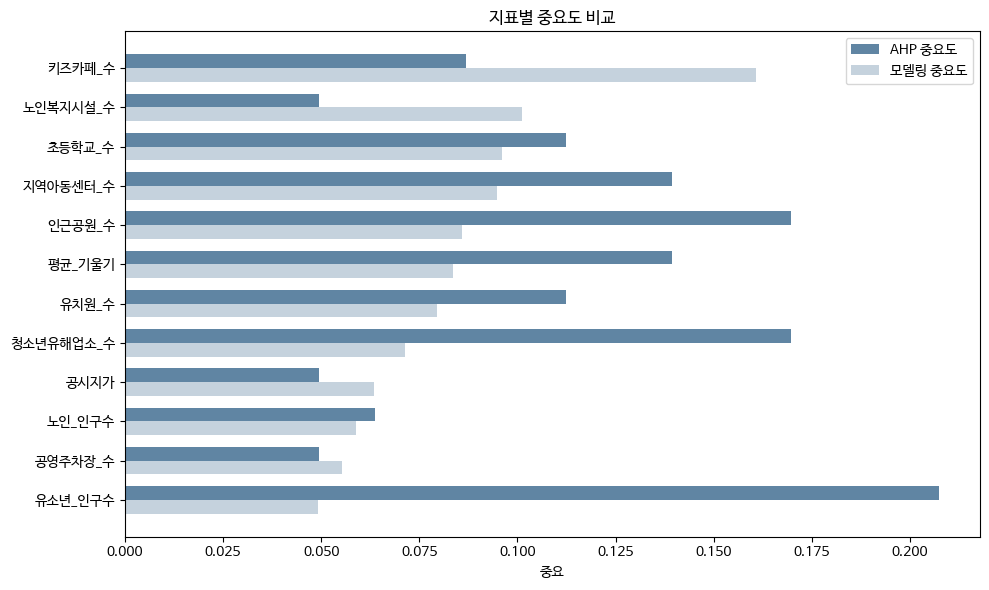

In [ ]:
y_pos = np.arange(len(df_ahp["지표"]))

plt.figure(figsize=(10, 6))

bar_width = 0.35
plt.barh(y_pos - bar_width/2, df_ahp["중요도"].values, bar_width, label='AHP 중요도', color='#6085a3')
plt.barh(y_pos + bar_width/2, df_modeling["중요도"].values, bar_width, label='모델링 중요도', color='#c5d2dd')

plt.yticks(y_pos, df_ahp["지표"].values)
plt.xlabel('중요')
plt.title('지표별 중요도 비교')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## Weighted Sum 계산

In [ ]:
score_columns = ahp_weights.keys()
weights = df_ahp.set_index('지표').loc[score_columns]['중요도'].values
df_norm['가중합_점수'] = df_norm[score_columns].dot(weights)
df = df_norm.sort_values(by='가중합_점수', ascending=False)
df

,도형ID,고유번호,법정동코드,법정동명,대장구분코드,대장구분명,지번,지번지목부호,기준연도,기준월,...,키즈카페_수,공원부지수,노인복지시설_수,공영주차장_수,주거부지수,평균_기울기,유소년_인구수,노인_인구수,도로측면_점수,가중합_점수
3,103390351,1121510400105770003,1121510400,서울특별시 광진구 광장동,1,일반,577-3,577-3잡,2024,1,...,0.0,1,0.00,0.0,33,0.505322,1.000000,0.870879,0.000000,0.883366
2,103390312,1121510400105770002,1121510400,서울특별시 광진구 광장동,1,일반,577-2,577-2잡,2024,1,...,0.0,3,0.25,0.0,127,0.548337,1.000000,0.870879,0.000000,0.822900
0,103389737,1121510100100290001,1121510100,서울특별시 광진구 중곡동,1,일반,29-1,29-1 대,2024,1,...,1.0,1,0.25,0.0,243,0.000000,0.177787,0.854396,1.000000,0.779651
1,103391159,1121510400103190033,1121510400,서울특별시 광진구 광장동,1,일반,319-33,319-33 대,2024,1,...,0.0,1,0.25,0.0,43,0.757428,1.000000,0.870879,0.333333,0.701659
5,103390177,1121510500106800081,1121510500,서울특별시 광진구 자양동,1,일반,680-81,680-81대,2024,1,...,0.0,2,0.75,0.0,350,0.879379,0.277766,0.822344,0.666667,0.694921
6,103390708,1121510500106900033,1121510500,서울특별시 광진구 자양동,1,일반,690-33,690-33대,2024,1,...,0.0,3,1.00,0.0,224,0.839246,0.314280,0.974359,1.000000,0.640447
4,103390918,1121510500100720001,1121510500,서울특별시 광진구 자양동,1,일반,72-1,72-1대,2024,1,...,1.0,2,0.00,0.0,75,1.000000,0.345577,1.000000,1.000000,0.622432
8,103391524,1121510900103740004,1121510900,서울특별시 광진구 군자동,1,일반,374-4,374-4 대,2024,1,...,0.0,8,0.25,1.0,157,0.867627,0.059987,0.038462,0.666667,0.429319
7,103390741,1121510700100010037,1121510700,서울특별시 광진구 화양동,1,일반,1-37,1-37대,2024,1,...,0.0,3,0.00,1.0,236,0.790022,0.000000,0.000000,0.666667,0.337290


In [ ]:
# df.to_csv("/content/drive/MyDrive/광진구 공모전 데이터/db/후보지w가중합.csv")

In [ ]:
df["주소"] = df["법정동명"] + " " + df["지번"]

In [ ]:
df[["주소", "도로측면_점수", "가중합_점수"]].sort_values(by=["가중합_점수", "도로측면_점수"], ascending=False)

,주소,도로측면_점수,가중합_점수
3,서울특별시 광진구 광장동 577-3,0.000000,0.883366
2,서울특별시 광진구 광장동 577-2,0.000000,0.822900
0,서울특별시 광진구 중곡동 29-1,1.000000,0.779651
1,서울특별시 광진구 광장동 319-33,0.333333,0.701659
5,서울특별시 광진구 자양동 680-81,0.666667,0.694921
6,서울특별시 광진구 자양동 690-33,1.000000,0.640447
4,서울특별시 광진구 자양동 72-1,1.000000,0.622432
8,서울특별시 광진구 군자동 374-4,0.666667,0.429319
7,서울특별시 광진구 화양동 1-37,0.666667,0.337290


In [ ]:
df[["주소", "가중합_점수"]].sort_values(by="가중합_점수", ascending=False)

,주소,가중합_점수
3,서울특별시 광진구 광장동 577-3,0.883366
2,서울특별시 광진구 광장동 577-2,0.822900
0,서울특별시 광진구 중곡동 29-1,0.779651
1,서울특별시 광진구 광장동 319-33,0.701659
5,서울특별시 광진구 자양동 680-81,0.694921
6,서울특별시 광진구 자양동 690-33,0.640447
4,서울특별시 광진구 자양동 72-1,0.622432
8,서울특별시 광진구 군자동 374-4,0.429319
7,서울특별시 광진구 화양동 1-37,0.337290


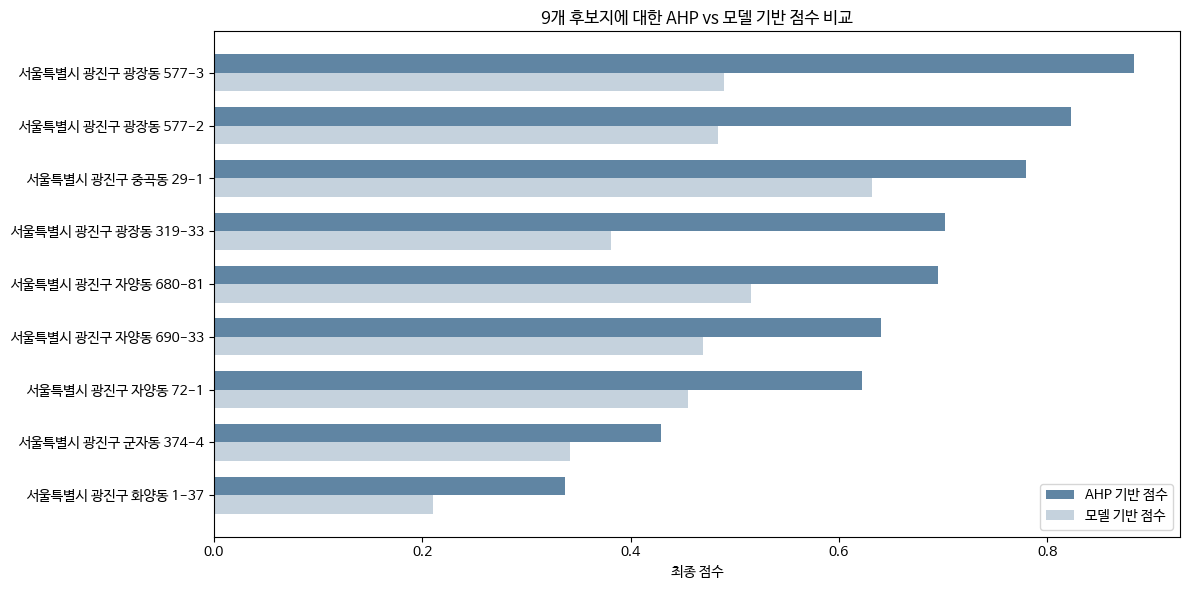

In [ ]:
from pandas.api.types import CategoricalDtype
y = np.arange(len(df["주소"]))
width = 0.35
cat_type = CategoricalDtype(categories=df["주소"].values, ordered=True)
df["주소"] = df["주소"].astype(cat_type)
df2["주소"] = df2["주소"].astype(cat_type)
df = df.sort_values('주소')
df2 = df2.sort_values('주소')

# 그래프
plt.figure(figsize=(12, 6))
plt.barh(y - width/2, df["가중합_점수"].values, width, label='AHP 기반 점수', color='#6085a3')
plt.barh(y + width/2, df2["가중합_점수"].values, width, label='모델 기반 점수', color='#c5d2dd')

plt.xlabel('최종 점수')
plt.title('9개 후보지에 대한 AHP vs 모델 기반 점수 비교')
plt.yticks(y, df["주소"].values)
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()